In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
import sys

In [5]:
import sys
sys.path.append('../../as_chem/')


### Get raw data

In [6]:
tox21_tasks = [
      'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
      'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
  ]

dataset_file = Path('../../datasets/tox21.csv.gz')

In [7]:
tox21 = pd.read_csv(dataset_file)

In [8]:
tox21

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
8010,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
8011,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
8012,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [9]:
tox21['smiles']

0                            CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1                               CCN1C(=O)NC(c2ccccc2)C1=O
2       CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3                         CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4                               CC(O)(P(=O)(O)O)P(=O)(O)O
                              ...                        
8009    CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
8010    CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
8011    C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
8012    C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...
8013              COc1ccc2c(c1OC)CN1CCc3cc4c(cc3C1C2)OCO4
Name: smiles, Length: 8014, dtype: object

In [10]:
train, test = train_test_split(tox21, test_size=.2 )
valid, test = train_test_split(test, test_size=.5)

### Molecule & Dataset class

In [11]:
#from deepchem.feat.graph_features import atom_features
from rdkit.Chem import MolFromSmiles
import numpy as np
import torch

#### Featurise data for the neural network

In [12]:
 def one_of_k_encoding(x, allowable_set):
  if x not in allowable_set:
    raise Exception("input {0} not in allowable set{1}:".format(
        x, allowable_set))
  return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
  """Maps inputs not in the allowable set to the last element."""
  if x not in allowable_set:
    x = allowable_set[-1]
  return list(map(lambda s: x == s, allowable_set))

def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
  """Helper method used to compute per-atom feature vectors.

  Many different featurization methods compute per-atom features such as ConvMolFeaturizer, WeaveFeaturizer. This method computes such features.

  Parameters
  ----------
  bool_id_feat: bool, optional
    Return an array of unique identifiers corresponding to atom type.
  explicit_H: bool, optional
    If true, model hydrogens explicitly
  use_chirality: bool, optional
    If true, use chirality information.
  """
  if bool_id_feat:
    return np.array([atom_to_id(atom)])
  else:
    from rdkit import Chem
    results = one_of_k_encoding_unk(
      atom.GetSymbol(),
      [
        'C',
        'N',
        'O',
        'S',
        'F',
        'Si',
        'P',
        'Cl',
        'Br',
        'Mg',
        'Na',
        'Ca',
        'Fe',
        'As',
        'Al',
        'I',
        'B',
        'V',
        'K',
        'Tl',
        'Yb',
        'Sb',
        'Sn',
        'Ag',
        'Pd',
        'Co',
        'Se',
        'Ti',
        'Zn',
        'H',  # H?
        'Li',
        'Ge',
        'Cu',
        'Au',
        'Ni',
        'Cd',
        'In',
        'Mn',
        'Zr',
        'Cr',
        'Pt',
        'Hg',
        'Pb',
        'Unknown'
      ]) + one_of_k_encoding(atom.GetDegree(),
                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
      results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
      try:
        results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
      except:
        results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)


In [13]:
from scipy.sparse import coo_matrix
import torch
import torch.sparse as sparse
from torch.utils.data import Dataset, DataLoader

In [14]:
class molecule(object):
    def __init__(self, data, smile_col, target_cols, norm=True):
        self._mol = self._smile2mol(data[smile_col])
        self._targets = self._extract_targets(data,target_cols)
        self._target_cols = target_cols
        self._mol_props = self._properties_matrix()    
        self._norm=norm
        if norm:
            self._adj_mat = self._normalise_adj()
        else:
            self._adj_mat = self._adj_mat()
    
        
    def _smile2mol(self, smile):
        return MolFromSmiles(smile)
    
    def _extract_targets(self, data, target_cols):
        targets ={}
        for t in target_cols:
            targets[t] = data[t]
        return targets
    
    def _properties_matrix(self):
        mol_props = [None]* self._mol.GetNumAtoms()
        for atom in self._mol.GetAtoms():
            mol_props[atom.GetIdx()] = atom_features(atom)
        return torch.tensor(mol_props, dtype=torch.float32)
    
    def _bond_index(self):
        mol = self._mol
        edges = self._self_bonds()
        for bond in iter(mol.GetBonds()):
            edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
            edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
        bond_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edges,bond_index
    
    def _adj_mat(self):
        _,b_i = self._bond_index()
        adj = torch.sparse_coo_tensor(b_i, torch.ones(b_i.shape[1]))
        return adj

    def _normalise_adj(self):
        adj_mat = self._adj_mat()
        degrees = sparse.sum(adj_mat,dim=1)
        d_ii = list(range(len(degrees)))
        D = torch.sparse_coo_tensor([d_ii,d_ii],degrees.values())
        D_inv_sqrt = D.pow(-0.5)
        norm_adj_mat = D_inv_sqrt.mm(adj_mat.to_dense()).mm(D_inv_sqrt.to_dense()) # need to get rid of dense conversions
        return norm_adj_mat    
    
    def _self_bonds(self):
        self_edges = [[i,i] for i in range(self._mol.GetNumAtoms())]
        return self_edges
    
    #@property
    def get_feats(self):
        return self._mol_props
    
    #@mol_props.setter
    def set_feats(self, new_feats:torch.tensor):
        self._mol_props = new_feats
    
    #@property
    def get_AM(self):
        return self._adj_mat
    
    #@property    
    def get_targets(self):
        return self._targets
    
    def get_model_inputs(self):
        return self.get_feats().requires_grad_(), self.get_AM(), self.get_targets(), self._target_cols
    def __repr__(self):
        return self._mol.__repr__() # improve this
    
    def __str__(self):
        pass
    

In [15]:
class molset(Dataset):
    def __init__(self,
                filename,
                smile_col,
                target_cols,
                normalise=False
                ):
        super(molset).__init__()
        self.df =  pd.read_csv(filename).dropna(subset=target_cols).reset_index()
        self.mols = self._smile2mol(smile_col, target_cols)
        if normalise:
            self.x_mu, self.x_std = self.std_mean()
            self.normalise_inputs()
        
    def _smile2mol(self, smile_col, target_cols):
        mols = {}
        for i, row in self.df.iterrows():
                mols[i] = molecule(row, smile_col, target_cols)
        
        return mols
     
    def std_mean(self):
        x_ =[self.mols[i].get_feats() for i in range(len(self.mols))]
        x = torch.cat(x_,0)
        x_mu, x_std = torch.std_mean(x,dim=0)
        x_std[x_std==0]=1 # as per https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
        return  x_mu, x_std
        
    def normalise_inputs(self):
        for i in range(len(self.mols)):
            x_norm = self.mols[i].get_feats().data.sub_(self.x_mu[None, :]).div_(self.x_std[None, :])
            self.mols[i].set_feats(x_norm)

    def __getitem__(self, idx):
        return self.mols[idx].get_model_inputs()
    
    def __len__(self):
        return len(self.df)
    

In [16]:
tox21_ale = molset(dataset_file, 'smiles',['SR-MMP'], normalise=False)
#                  ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
#                   'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP'])

RDKit WARNING: [09:18:27] WARNING: not removing hydrogen atom without neighbors


In [17]:
tox21_ale[0][3]

['SR-MMP']

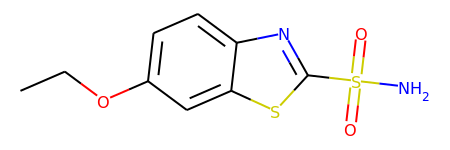

In [45]:
tox21_ale.mols[0]._mol

In [25]:
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

In [41]:
IPythonConsole.drawMol3D(tox21_ale.mols[0])

NameError: name 'py3Dmol' is not defined

In [46]:
sample_mols = [tox21_ale.mols[i]._mol for i in range(10)]

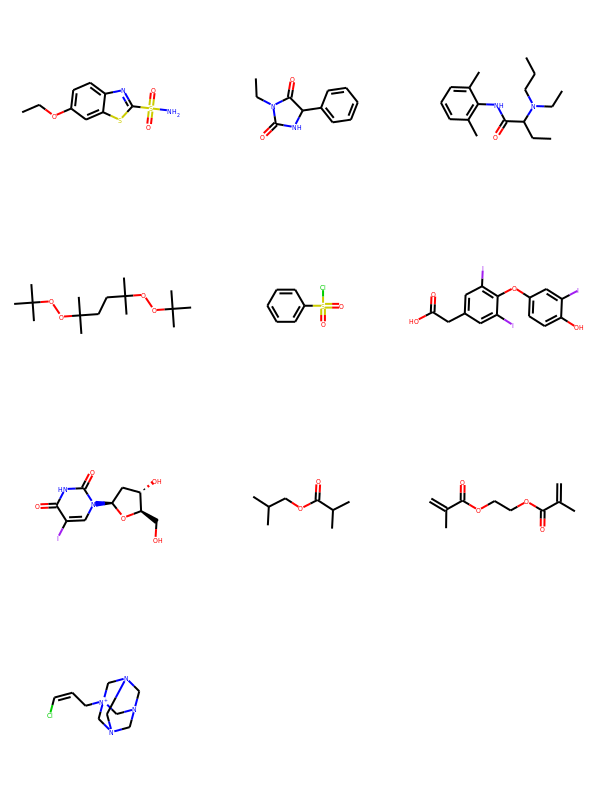

In [47]:
MolsToGridImage(sample_mols,)

In [18]:
tox21_ale[0]

(tensor([[1., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True),
 tensor([[0.5000, 0.4082, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4082, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3333, 0.3333, 0.2887, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2887, 0.2500, 0.2887, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2887],
         [0.0000, 0.0000, 0.0000, 0.2887, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000

### Build net

#### From raw python + pytorch

In [23]:
import torch.nn as nn
from typing import List
from functools import partial

In [24]:
class gcn_layer(nn.Module):
    def __init__(self, in_d:int, out_d:int):
        super(gcn_layer, self).__init__()
        self.in_d = in_d
        self.out_d = out_d
        self.linear = nn.Linear(in_d,out_d)

    def forward(self, features, bonds):
        h = self.linear(features)
        h = torch.matmul(bonds,h)

        return h

"""class masked_linear(nn.Module):
    def __init__(self, in_d:int, out_d:int):
        super(masked_linear, self).__init__()
        self.in_d = in_d
        self.out_d = out_d
        self.weight = nn.Linear(in_d,out_d)
        
        def forward(self, h, mask):
        h = torch.matmul(mask,h)
        h = self.weight(h)
        return" h
"""

class AS_GCN(nn.Module):
    def __init__(self, input_features:int, hidden_channels:List[int], activation: str, dropout: float, out_classes:int):
        super(AS_GCN, self).__init__()
        self.convolutions = nn.ModuleList()
        in_d, out_d = input_features, None
        for d in hidden_channels:
            out_d = d 
            conv_layer = gcn_layer(in_d, out_d)
            self.convolutions.append(conv_layer)
            in_d = out_d
        
        activations = {
            'relu': nn.ReLU,
            'leaky_relu': nn.LeakyReLU,
            'sigmoid': nn.Sigmoid
        }
        assert activation in activations, f'Activation not supported. Choose from {[a for a in activations.keys()]}'
        self.nonlinearity = activations[activation]()
        self.nonlinearity_name = activation
        self.dropout = nn.Dropout(dropout)
        self.final_conv = gcn_layer(out_d, out_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X, A, graph_sizes):

        #bonds = A
        #h = None
        for conv in self.convolutions:
            h = conv(X, A)
            h = self.nonlinearity(h)
            X = self.dropout(h)
        
        out =  self.final_conv(X,A)
        out = self.sigmoid(out)
        out = torch.stack([g.mean() for g in out.split(graph_sizes)])
        out.retain_grad()
        return (out)
    
    def init_weights(self):
        for n,p in self.named_parameters():
            if n.endswith('weight'):
                if self.nonlinearity_name in ['relu', 'leaky_relu']:
#                     nn.init.kaiming_uniform_(p.data,nonlinearity=self.nonlinearity_name)
                    nn.init.xavier_uniform_(p.data)

                else:
                    nn.init.xavier_uniform_(p.data)
                    

### Build training loop

### batching

#### custom collate function 

In [25]:
from torch import block_diag

In [17]:
class graph_inputs(object):
    def __init__(self,input_list):
        self.X = input_list[0]
        self.A = input_list[1]
        self.y = input_list[2]
        #self.target = [input_list[3]]

class batch_graph():
    def __init__(self, inputs):
        Xs = [b.X for b in inputs]
        As = [b.A for b in inputs]
        Ys = [b.y for b in inputs]
        
        self.A = torch.block_diag(*As).cuda()
        self.X = torch.cat(Xs).cuda()
        self.Y = Ys
        self.graph_sizes = [len(x) for x in Xs]
        #self.target = [input_list[3]]

def graph_collate(batch):
    inputs = batch_graph([graph_inputs(sample) for sample in batch])
    return inputs

### Train/Test split

In [18]:
def split(dataset, splits_p):
    splits = len(dataset)*np.array(splits_p)
    splits = [int(p) for p in list(splits)]
    return splits

In [19]:
[int(p) for p in list(float(len(tox21_ale))*np.array([.9,.1]))]

[5328, 592]

In [20]:
len(tox21_ale) - (4736+1184)

0

In [21]:
train, test = torch.utils.data.random_split(tox21_ale, split(tox21_ale, [.8, .2]),generator=torch.Generator().manual_seed(42))

In [22]:
train_loader = DataLoader(train, batch_size=100, collate_fn=graph_collate)

### Training loop

In [23]:
from torch.optim import Adam

In [24]:
torch.cuda.set_device(0)

In [25]:
model = AS_GCN(75,[300,300,300],'relu',0.,1)

In [26]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

convolutions.0.linear.weight
convolutions.0.linear.bias
convolutions.1.linear.weight
convolutions.1.linear.bias
convolutions.2.linear.weight
convolutions.2.linear.bias
fc.linear.weight
fc.linear.bias


In [27]:
model.cuda()

AS_GCN(
  (convolutions): ModuleList(
    (0): gcn_layer(
      (linear): Linear(in_features=75, out_features=300, bias=True)
    )
    (1): gcn_layer(
      (linear): Linear(in_features=300, out_features=300, bias=True)
    )
    (2): gcn_layer(
      (linear): Linear(in_features=300, out_features=300, bias=True)
    )
  )
  (nonlinearity): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): gcn_layer(
    (linear): Linear(in_features=300, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [28]:
optim = Adam(model.parameters(),lr=0.002)
bce = nn.BCELoss().cuda()
#bce.cuda()

target = 'NR-AR'
batch_eg = next(iter(as_loader))    
optim.zero_grad()
batch_out = model.forward(batch_eg.X, batch_eg.A)
graph_out =batch_out.split(batch_eg.graph_sizes)
predictions = torch.tensor([torch.mean(g) for g in graph_out],  device='cuda',requires_grad=True)
y = torch.tensor([y[target] for y in batch_eg.Y], device='cuda')
loss = bce(predictions,y).cuda()
loss.backward()


graph_out =batch_out.split(batch_eg.graph_sizes)
predictions = torch.tensor([torch.mean(g) for g in graph_out],  device='cuda',requires_grad=True)
y = torch.tensor([y[target] for y in batch_eg.Y], device='cuda')
loss = bce(predictions,y).cuda()
loss.backward()


In [29]:
from torch.utils.tensorboard import SummaryWriter

In [53]:
predictions = None
target = 'SR-MMP'
writer = SummaryWriter()
model.train()
model.init_weights()
epochs = 100
for e in range(epochs):
    for b_i,batch in enumerate(train_loader):
        optim.zero_grad()
        predictions = model.forward(batch.X, batch.A, batch.graph_sizes)
        y = torch.tensor([y[target] for y in batch.Y], device='cuda')
        loss = bce(predictions,y)#.cuda()
        loss.backward()
        optim.step()
        if (b_i%50==0):
            batch_num =  e*(len(train_loader.dataset) + b_i)
            writer.add_scalar('BCE loss: Train', loss.item(), batch_num)
            binary_predictions = (predictions>0.5).float()
            correct = (binary_predictions == y.float()).float().sum()
            print(f"Epoch {e}/{epochs}, Loss: {loss.item()}, Accuracy: {correct/len(y)}")
            for n,p in model.named_parameters():
                if 'bias' not in n:
                    writer.add_scalar(f'{n}:mean', p.mean().item(),batch_num)
                    writer.add_scalar(f'{n}:std', p.std().item(),batch_num)
writer.close()    

Epoch 0/100, Loss: 0.11437339335680008, Accuracy: 0.9599999785423279
Epoch 1/100, Loss: 0.12953640520572662, Accuracy: 0.949999988079071
Epoch 2/100, Loss: 0.11907684057950974, Accuracy: 0.9599999785423279
Epoch 3/100, Loss: 0.13538144528865814, Accuracy: 0.9399999976158142
Epoch 4/100, Loss: 0.12614187598228455, Accuracy: 0.949999988079071
Epoch 5/100, Loss: 0.12632666528224945, Accuracy: 0.949999988079071
Epoch 6/100, Loss: 0.12371528148651123, Accuracy: 0.949999988079071
Epoch 7/100, Loss: 0.11600169539451599, Accuracy: 0.949999988079071
Epoch 8/100, Loss: 0.12190364301204681, Accuracy: 0.949999988079071
Epoch 9/100, Loss: 0.12406125664710999, Accuracy: 0.949999988079071
Epoch 10/100, Loss: 0.11846152693033218, Accuracy: 0.949999988079071
Epoch 11/100, Loss: 0.14810030162334442, Accuracy: 0.949999988079071
Epoch 12/100, Loss: 0.12472091615200043, Accuracy: 0.949999988079071
Epoch 13/100, Loss: 0.12452718615531921, Accuracy: 0.949999988079071
Epoch 14/100, Loss: 0.12577931582927704, 

### Evaluation

In [31]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [54]:
model.eval()
test_loader = DataLoader(test, batch_size=100, collate_fn=graph_collate)

In [55]:
cat_predictions, cat_y = [], []
for b_i,batch in enumerate(test_loader):
        predictions = model.forward(batch.X, batch.A, batch.graph_sizes)
        y = torch.tensor([y[target] for y in batch.Y], device='cuda')
        cat_predictions.append(predictions)
        cat_y.append(y)
        
test_predictions = torch.cat(cat_predictions)
test_y =  torch.cat(cat_y)
aps = average_precision_score(test_y.cpu().numpy(), test_predictions.detach().cpu().numpy())
roc_auc = roc_auc_score(test_y.cpu().numpy(), test_predictions.detach().cpu().numpy())
print(
    f'Model performance:',
    f'Average precision score: {aps}',
    f'ROC AUC score: {roc_auc}', 
    sep='\n')

Model performance:
Average precision score: 0.5799012207408677
ROC AUC score: 0.8519013880855986
